<div style="background-color:rgba(20, 20, 20, 0.8); color:white; padding:10pt" >    

# **Lab Introduction to Image Processing**
&mdash; **`alain.lebret@ensicaen.fr`** &mdash;

### Part 3: Spatial Filters

</div>

## Introduction

Digital images are subject to various types of noise. Noise is the result of errors in the image acquisition process and results in pixel values that do not reflect the actual intensities. The insertion of noise into an image largely depends on how the image was produced. For example:

If the image is digitized from a photograph, the grain of the photograph can be a source of noise. Noise can also result from physical damage to the paper photograph, or be introduced by the scanning device itself.
If the image is acquired directly in a digital format, the data retrieval mechanism, such as the CCD sensor, may introduce noise.
Transmitting an image over a transmission channel can also introduce noise.
In the spatial domain, it is possible to use linear filtering to remove certain types of noise. Filters such as averaging filters or Gaussian filters are suitable. For example, an averaging filter will be useful for removing noise due to the grain of a photograph. Since each pixel depends on the average of the pixels in its neighborhood, local variations caused by graining are thus reduced. The non-linear median filter, on the other hand, is much less sensitive to extreme values (called outliers) than an averaging filter can be. Median filtering is therefore more able to remove these outliers without reducing the sharpness of the image.

In the upcoming sessions, we will see that moving into the frequency domain also allows us to denoise an image using low-pass filters.


## Dependencies

In [1]:
#
# Loads required libraries 
#
import math
import numpy as np
import skimage              # scikit-image
from skimage import data    # some images to use
from skimage import io      # open, write, etc. image files
from skimage import color   # conversion between color spaces 
from skimage import filters # threshold_mean 
from skimage import util    # random_noise 
from skimage.morphology import disk # to use with "median" filter
from matplotlib import pyplot as plt

#
# Uncomments the lines below if using Google Colab
#
#from google.colab import drive
#from google.colab.patches import cv2_imshow

In [4]:
root_path = './ressources'
smaller = root_path + '/256x256'
medium = root_path + '/512x512'
various = root_path + '/divers'

## 1. Introduction to Image Noise

In the realm of digital image processing, noise refers to random variations of brightness or color information, which can significantly degrade the quality of an image. Various types of noise can be encountered in images, each with distinct characteristics and sources:

- **Gaussian Noise**: This type of noise follows a Gaussian distribution and can be caused by sensor noise due to poor illumination and/or high temperature, and electronic circuit noise in image acquisition.
- **Salt-and-Pepper Noise**: This noise introduces sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels. It can be caused by faulty memory locations in hardware, malfunctioning pixel elements in the camera sensors, or during transmission, such as in wireless communication.
- **Poisson Noise**: This noise model is appropriate for representing photon counting in astronomical images or in scientific microscopy, where the observed number of photons follows a Poisson distribution.
- **Speckle Noise**: Commonly seen in medical images (especially ultrasound), this multiplicative noise can be modeled by multiplying the pixel value by a uniform or Gaussian random variable.

Simulating these noises can be crucial for developing and testing image processing algorithms to ensure robustness. To generate various types of noise in an image, Scikit-image provides the [`random_noise()`](https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.random_noise) function in its `util` module. 

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Exercise No. 1.1**

1. In your opinion, what type of noise is present in the images "girlface_noisy1.png", "girlface_noisy2.png", and "girlface_noisy3.png"?
2. Verify your hypotheses by adding noise to the image "girlface.png". 

---
    
</div>

In [7]:
#
# TO COMPLETE WITH YOUR CODE
#

# Add salt-and-pepper, gaussian and speckle noises to the image.
girlface = io.imread(medium + "/girlface.png")
girlface_noisy1 = util.random_noise(girlface, mode = 's&p', amount = 0.1)
girlface_noisy2 = util.random_noise(girlface, mode = 'gaussian')
girlface_noisy3 = util.random_noise(girlface, mode = 'speckle')
#io.imsave(medium + "/girlface_noisy1.png", util.img_as_ubyte(girlface_noisy1))
#io.imsave(medium + "/girlface_noisy2.png", util.img_as_ubyte(girlface_noisy2))
#io.imsave(medium + "/girlface_noisy3.png", util.img_as_ubyte(girlface_noisy3))

### Note

A number of *Scikit-image* functions, such as the one that applies noise (the [`random_noise()`](https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.random_noise) function from the `util` module), return images with values in the range $[-1, 1]$. *Scikit-image* functions can handle this transformation and automatically bring images back into the $[0, 255]$ range. However, if you write your own functions, it may be necessary to normalize your images to bring them back into the $[0, 255]$ range. This operation is performed by the following transformation: \
$I_{\text{new}} = 255 \times \left( \frac{I_{\text{old}} - \text{min}(I_{\text{old}})}{\text{max}(I_{\text{old}}) - \text{min}(I_{\text{old}})} \right)$

Here is a `normalize_image()` function that will help you perform this operation:

```python
def normalize_image(image):
    """
    Normalize the image so that it has values in the range [0, 255] and converts it to uint8.
    
    Parameters:
        image : np.array
            The input image with values in the range [-1, 1].
    
    Returns:
        np.array
            The normalized image with values in the range [0, 255] and of type uint8.
    """
    # Normalize the image to have values in the range [0, 1]
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Extend the values to be in the range [0, 255] and convert to uint8
    return np.uint8(normalized_image * 255)
```

## 2. Image Denoising

Filtering methods for reducing noise in images include **spatial filters** and **frequency filters**.

Among the most used spatial filters, we find:

- **Mean filter**: A linear filter that replaces each pixel in the image with the average of neighboring pixels, including itself. This type of filter is effective for *reducing Gaussian noise*. The operation involves a convolution product between the original image $I$ and a kernel $K$ (a matrix) whose all values are divided by its number $N$ of elements. For example, a 3x3 kernel can be defined as follows: $K = \frac{1}{9} \times \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$. \
    $ I_{\text{filtered}}(x, y) = (I * K)(x, y) = \sum\limits_{m=-a}^{a} \sum\limits_{n=-b}^{b} I(x-m, y-n) \cdot K(m, n) $ 
    where $a$ and $b$ are respectively half the width and height of the kernel, $x$ and $y$ are the coordinates of the pixel being processed in the image $I$, $m$ and $n$ are the coordinates of the pixel being processed in the kernel $K$.  
- **Gaussian filter**: A linear filter that uses a kernel $K$ based on the Gaussian function to smooth the image. It gives more weight to pixels close to the center of the kernel and less weight to distant pixels. $I_{\text{filtered}}(x, y)$ still corresponds to the convolution product of $I$ by the kernel $K$ whose elements are estimated by the function $G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$ where $\sigma$ is the standard deviation of the Gaussian. 
- **Median filter**: A non-linear filter that replaces each pixel in the image with the median value of neighboring pixels in a sliding window that scans the entire image. The size of this window (or mask) is usually odd (for example, 3$\times$3, 5$\times$5) so that there is a central pixel. It is a filter that is particularly effective for *eliminating "salt and pepper" noise*. \
    $ I_{\text{filtered}}(x, y) = \text{median}\{ I(x+i, y+j) : -k \leq i \leq k, -l \leq j \leq l \} $
    where $k$ and $l$ determine the size of the neighborhood, $x$ and $y$ are the coordinates of the pixel being processed.
- **Bilateral filter**: A non-linear filter that takes into account both spatial proximity and pixel intensity. It is effective in reducing noise while preserving edges in the image.
    $ I_{\text{filtered}}(x, y) = \frac{\sum\limits_{i=-k}^{k} \sum\limits_{j=-l}^{l} I(x+i, y+j) \cdot W_s(i, j) \cdot W_c(I(x+i, y+j), I(x, y))}{\sum\limits_{i=-k}^{k} \sum\limits_{j=-l}^{l} W_s(i, j) \cdot W_c(I(x+i, y+j), I(x, y))} $
    $W_s$ is a spatial weight function (often a Gaussian), $W_c$ is the intensity difference weight function (also often a Gaussian), $k$ and $l$ determine the size of the neighborhood, $x$ and $y$ are the coordinates of the pixel being processed.

*Scikit-image* offers in its `filters` module the "mean" ([`rank.mean()`](https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#skimage.filters.rank.mean)), "gaussian" ([`gaussian()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.gaussian)), and "median" ([`median()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.median)) filters. The "bilateral" filter ([`denoise_bilateral()`](https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.denoise_bilateral)) is offered in the `restoration` module.

### Convolution Product

The filters of *Scikit-image* implement an optimized version of the convolution operation. However, if you want to write your own filters, it is necessary to have your own function. The `convolve2D()` function below allows for the convolution between a 2D image and a kernel. By default, the convolution is performed on the left half of the image in order to compare the result.

```python
def convolve2D(input_image, filter_kernel, half=True):
    """ Left half part or whole image convolution using the given kernel """
    s = input_image.shape
    py = (filter_kernel.shape[0]-1)/2
    px = (filter_kernel.shape[1]-1)/2
    filtered_image = input_image.copy()
    if half:
        imax = s[1]/2
    else:
        imax = s[1]-px
    for i in range(int(px), int(imax)):
        for j in range(int(py), int(s[0]-py)):
            pixel_sum = 0.0
            for k in range(-int(px),int(px)+1):
                for l in range(-int(py),int(py)+1):
                    pixel_sum += input_image[int(j+l)][int(i+k)]*filter_kernel[int(l+py)][int(k+px)]
            filtered_image[j][i] = pixel_sum
    return filtered_image
```

### Denoising with Mean Filter

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Exercise No. 2.1**

Using the previous `convolve2D()` function, perform noise reduction in the images "girlface_noisy1.png", "girlface_noisy2.png", and "girlface_noisy3.png" and display the results for the following filters:

1. 3x3 Mean filter (weight 1/9).
2. 5x5 Mean filter (weight 1/25).
3. 15x15 Mean filter (weight 1/225).

Note: The kernel $K$ will be created using the [`ones()`](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) function from *Numpy*. For example: `K = np.ones((3, 3)) * 1.0/9`.

---    
</div>

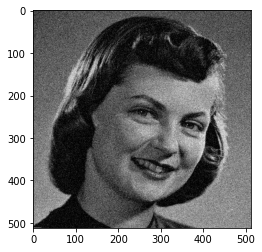

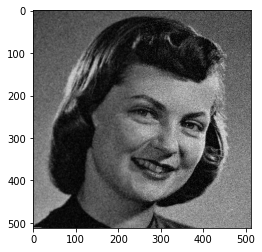

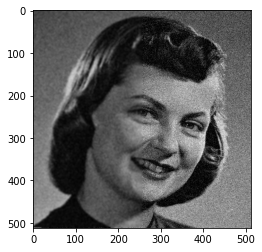

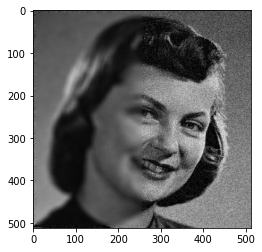

In [17]:
#
# TO COMPLETE WITH YOUR CODE
#

img = io.imread(medium + "/girlface_noisy2.png")
plt.imshow(img, cmap='gray')

# A first small filter
h = np.ones((3, 3)) * 1.0/9
Y = convolve2D(img, h, True)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')

# A lesser small filter
h = np.ones((5, 5)) * 1.0/25
Y = convolve2D(img, h, True)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')

# Another bigger filter
h = np.ones((15, 15))*1.0/225
Y = convolve2D(img, h, True)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')

### Denoising with Gaussian Filter
The function `gaussianFilter()` below performs a Gaussian filter of a given width:

```python
def gaussianFilter(width):
    epsilon = 0.05
    sigma = width * 1.0 / math.sqrt(-2 * math.log(epsilon))
    h = np.zeros((2*width + 1, 2*width  + 1))
    sum = 0
    for m in range(-width, width+1):
        for n in range(-width, width+1):
            h[m+width][n+width] = math.exp(-(n*n + m*m)/(2*sigma*sigma))
            sum += h[m+width][n+width]
    h = h/sum
    return h
```

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Exercise No. 2.2**

Using the previous `convolve2D()` and `gaussianFilter()` functions, perform noise reduction in the images "girlface_noisy1.png", "girlface_noisy2.png", and "girlface_noisy3.png" and display the results for Gaussian filters of width 3, 5, and 7.

---
    
</div>

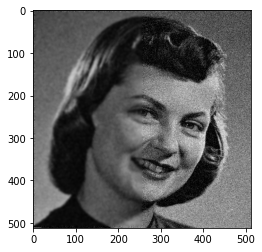

In [24]:
#
# TO COMPLETE WITH YOUR CODE
#
# A small gaussian filter
h = gaussianFilter(5)
Y = convolve2D(img, h, True)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')


### Denoising with Median Filter

This time, we will use the [`median()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.median) function from the `filters` module of the _Scikit-image_ library, which directly performs the convolution.

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Exercise No. 2.3**

1. Using the [`median()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.median) function and the [`disk()`](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) function from the `morphology` module of the _Scikit-image_ library, perform noise reduction on the images "girlface_noisy1.png", "girlface_noisy2.png", and "girlface_noisy3.png" using disks of size 5, 7, and 9 and display the results.
2. Compare the different filters.

---

</div>

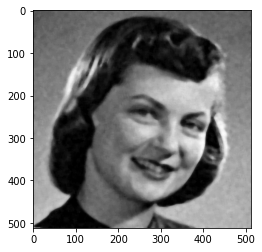

In [25]:
#
# TO COMPLETE WITH YOUR CODE
#

# A median filter
Y = filters.median(img, disk(5))
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')

## 3. Edge Extraction and Refinement

In addition to noise reduction functions, the `filters` module of *Scikit-image* includes most functions that perform edge extraction and refinement using spatial filters.

### Edge Extraction

Edge extraction is a crucial operation in image processing and computer vision to detect regions in an image where there is a sudden change in intensity. Edges can reveal significant details and shapes in the image and are often used to segment and identify objects in a scene. Here's a brief explanation of the "Prewitt", "Roberts", and "Sobel" methods for edge extraction:

#### Prewitt Operator

The Prewitt operator uses a convolution operator to detect areas of the image where there is an abrupt change in intensity, which often indicates the presence of an edge. The operator uses two 3$\times$3 kernels (one for horizontal changes, the other for vertical changes) to calculate approximations of the image gradient derivatives, thereby highlighting regions of intensity change. The kernels are as follows:

$ G_x = \begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix} $
and
$ G_y = \begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix} $

The gradient magnitude is then calculated as follows:
$ G = \sqrt{{G_x}^2 + {G_y}^2} $

#### Roberts Operator

The Roberts operator is particularly effective for detecting edges that are at 45 degrees in the image. It uses a pair of 2x2 kernels that are convolved with the original image to calculate approximations of the gradient derivatives. The Roberts operator is known for its simplicity and computational speed but is less effective at detecting subtle edges compared to other operators. The kernels are as follows:

$ G_x = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix} $
and
$ G_y = \begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix} $

The gradient magnitude is calculated similarly to the Prewitt operator:
$ G = \sqrt{{G_x}^2 + {G_y}^2} $

#### Sobel Operator

The Sobel operator is similar to Prewitt in terms of detecting horizontal and vertical intensity changes but uses different convolution kernels that place greater weighting on pixels that are in the center of the kernel. The Sobel operator is often preferred for its robustness and ability to highlight edges even in a noisy image. The kernels are as follows:

$ G_x = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix} $
and
$ G_y = \begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix} $

And the gradient magnitude is:
$ G = \sqrt{{G_x}^2 + {G_y}^2} $

In all cases, $G_ x$ and $G_ y$ are applied to the original image via convolution, and the gradient magnitude 
$G$ is used to determine the presence of an edge. If $G$ is above a certain threshold, an edge is detected. The directions of the edges can also be calculated using the arctangent of the ratio of the two gradients: 
$ \theta = \arctan2(G_y, G_x) $.

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Exercise No. 3.1**

1. Create two synthetic grayscale images, one containing a white square on a black background, and the other a white circle on a black background. Apply the _Prewitt_ ([`prewitt()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.prewitt)), _Roberts_ ([`roberts()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.roberts)), and _Sobel_ ([`sobel()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel)) operators to them. Compare the results.
2. Repeat with two more realistic images (character and building).
3. Are the operators encountered here suitable for all images?

---    
</div>

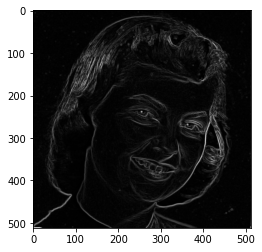

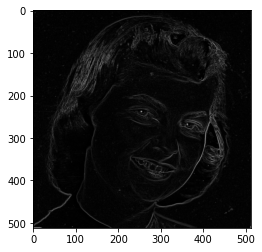

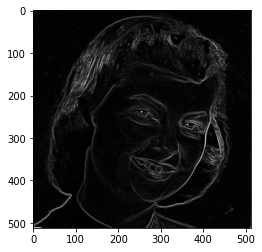

In [26]:
#
# TO COMPLETE WITH YOUR CODE
#

Y = filters.prewitt(girlface)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')
Y = filters.roberts(girlface)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')
Y = filters.sobel(girlface)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')

### Edge Refinement

#### Laplace Operator

The Laplace operator is used in the imaging field for edge detection. It is based on the second spatial derivative of the image to find regions where the image intensity changes. The Laplace operator $\nabla^2 f$
is defined as the sum of the second derivatives with respect to the $x$ and $y$ axes: 
$ \nabla^2 f = \frac{{\partial^2 f}}{{\partial x^2}} + \frac{{\partial^2 f}}{{\partial y^2}} $

In the context of image processing, the Laplace operator is often approximated using the following convolution kernel:
$ L = \begin{bmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1
\end{bmatrix}$

*Scikit-image* provides the [`laplace()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.laplace) function that performs this operator.

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Exercise No. 3.2**

1. On the two previous synthetic images, apply a Gaussian filter of width 7 before performing edge extraction with the Laplace operator.
2. Perform edge sharpening by subtracting the edge image from the blurred image and compare the results.
3. Repeat with the two more realistic images used previously (character and building).  

---
    
</div>

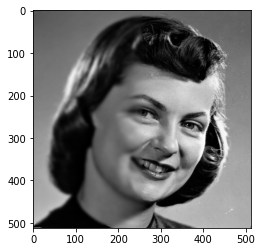

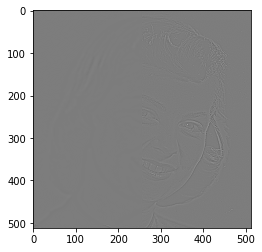

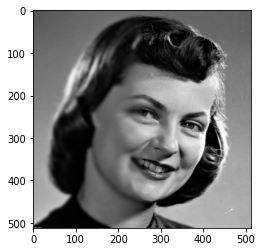

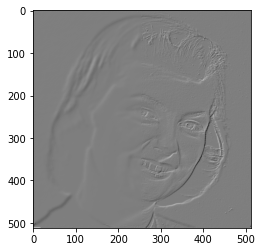

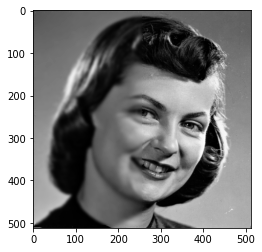

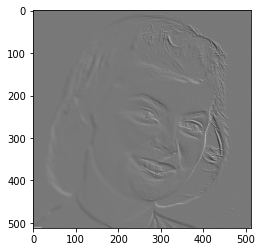

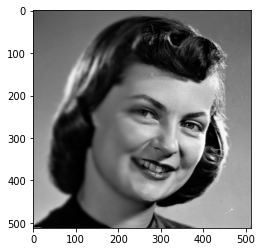

In [27]:
#
# TO COMPLETE WITH YOUR CODE
#

h = gaussianFilter(7)
img = convolve2D(girlface, h, True)
plt.figure(figsize = (4, 4))
plt.imshow(img, cmap = 'gray')

Y = filters.laplace(img)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')
Y = img-Y
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')
Y = filters.roberts_pos_diag(img)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')
Y = img-Y
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')
Y = filters.roberts_neg_diag(img)
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')
Y = img-Y
plt.figure(figsize = (4, 4))
plt.imshow(Y, cmap = 'gray')

## To recap

In this practical work, we delved into spatial filters, exploring their application in noise management and edge extraction within images. Various filters, such as Mean, Gaussian, and Median for denoising, as well as Prewitt, Roberts, Sobel, and Laplace for edge detection, were explored and implemented using the *Scikit-image* library. This foundational knowledge in spatial filtering sets the stage for the upcoming session, which will pivot towards exploring frequency filters in image processing.